In [3]:
#reading image
import cv2
import numpy as np
img = cv2.imread('f:/lane/lane_3.png')
cv2.imshow('img',img)
cv2.waitKey( )
cv2.destroyAllWindows()

In [4]:
print(img.shape)   #BGR 默认形式   高（y）  宽（x）  通道（3）

(720, 1280, 3)


In [5]:
print(img.shape[:])

(720, 1280, 3)


In [6]:
print(img.shape[1:])

(1280, 3)


In [7]:
print(img.shape[1::-1])  #  宽（x）   高（y）

(1280, 720)


In [8]:
#图像灰度化处理
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

cv2.imshow('gray',gray)
cv2.waitKey( )
cv2.destroyAllWindows()

In [9]:
#读图直接变成一张灰度图
import cv2
import numpy as np

gray = cv2.imread('f:/lane/lane_3.png',0)

cv2.imshow('gray',gray)
cv2.waitKey( )
cv2.destroyAllWindows()

In [10]:
#二值化处理（黑白）
binary = np.zeros_like(gray)
binary[(gray>=127)]=255

cv2.imshow('binary',binary)
cv2.waitKey( )
cv2.destroyAllWindows()

### 处理毛刺点
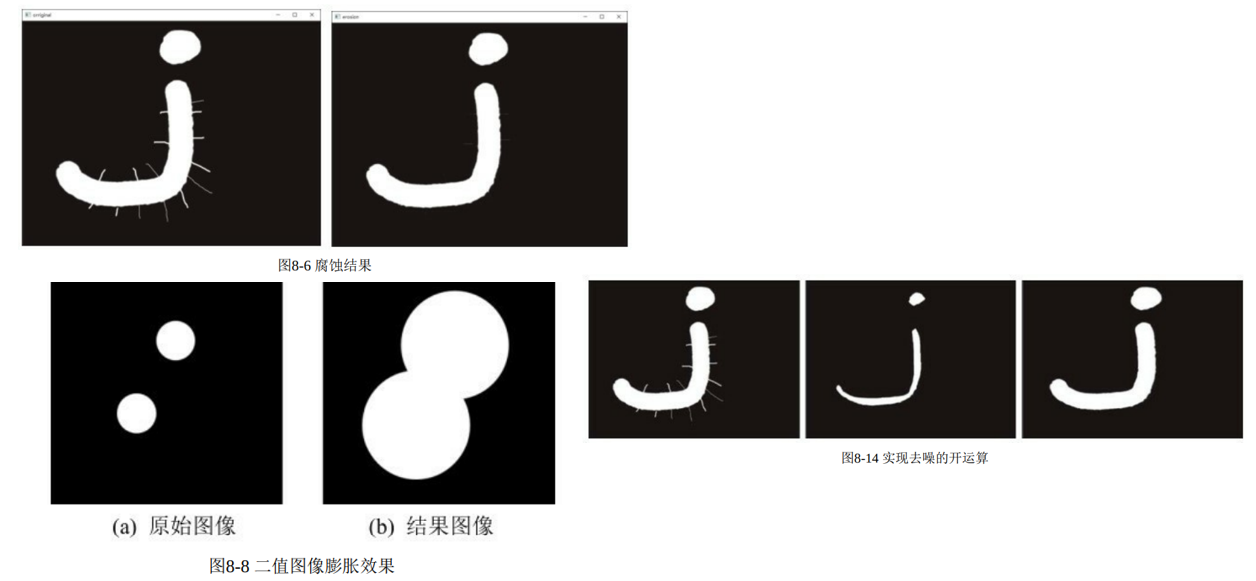

In [11]:
#去噪的开运算
kernel = np.ones((3,3),np.uint8)
binary_Blur = cv2.morphologyEx(binary,cv2.MORPH_OPEN,kernel)

cv2.imshow('binary',binary)
cv2.imshow('binary_Blur',binary_Blur)
cv2.waitKey( )
cv2.destroyAllWindows()

### 透视变化
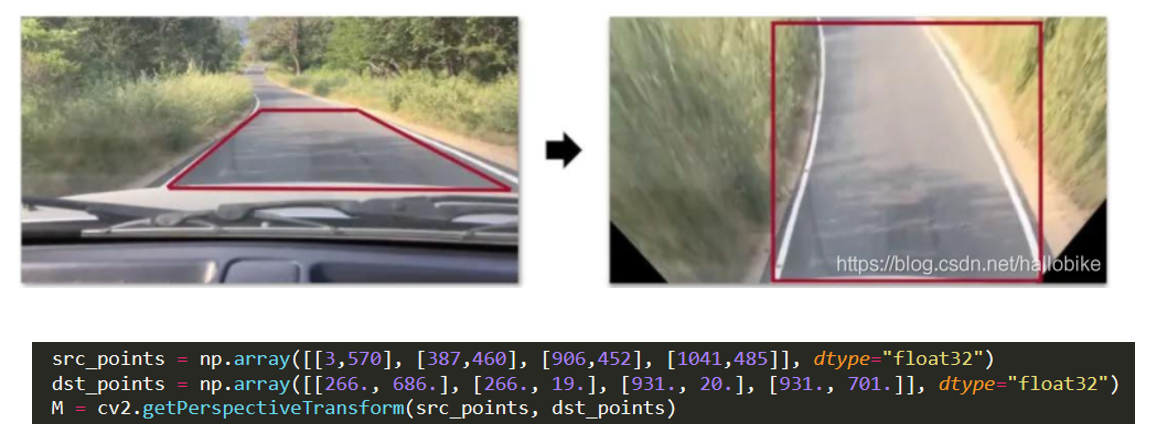

In [12]:
#透视变换
startx = 300
starty = 700
length_pers = 680
width_pers = 680

dstps = np.float32([[(startx,starty),(startx,starty-length_pers),(startx+width_pers,starty-length_pers),
                    (startx+width_pers,starty)]])

srcps = np.array([[238,681],[546,497],[762,483],[1069,678]],dtype = 'float32')

M = cv2.getPerspectiveTransform(srcps,dstps)

binary_warped = cv2.warpPerspective(binary_Blur,M,binary_Blur.shape[1::-1],flags=cv2.INTER_LINEAR)


cv2.imshow('binary_Blur',binary_Blur)
cv2.imshow('binary_warped',binary_warped)
cv2.waitKey( )
cv2.destroyAllWindows()

### 直方图   目的-确定起始点
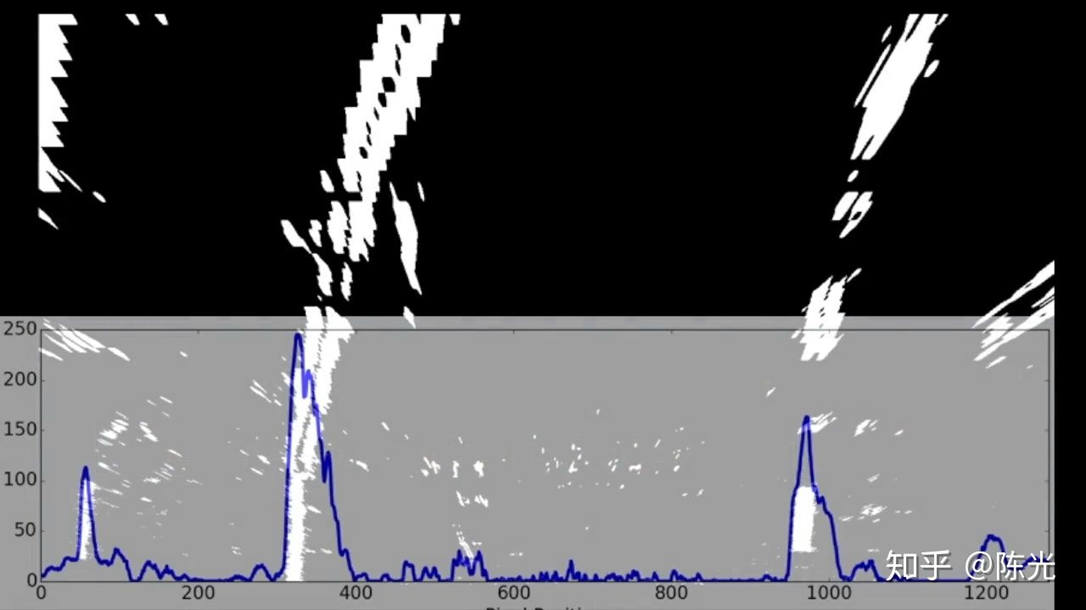

In [13]:
#直方图
img1 = cv2.cvtColor(binary_warped,cv2.COLOR_GRAY2BGR) #为了画直方图颜色图
h=binary_warped.shape[0]
histogram = np.sum(binary_warped[h//2:,:],axis=0)

num = 0 
for num in range(len(histogram)-1):
    cv2.line(img1,(num,int(720-histogram[num]/250)),(num+1,int(720-histogram[num+1]/250)),(0,0,255),8)
             
lane_base = np.argmax(histogram)
print(lane_base)
cv2.imshow('img1',img1)
cv2.waitKey( )
cv2.destroyAllWindows()

301


### 滑窗取点
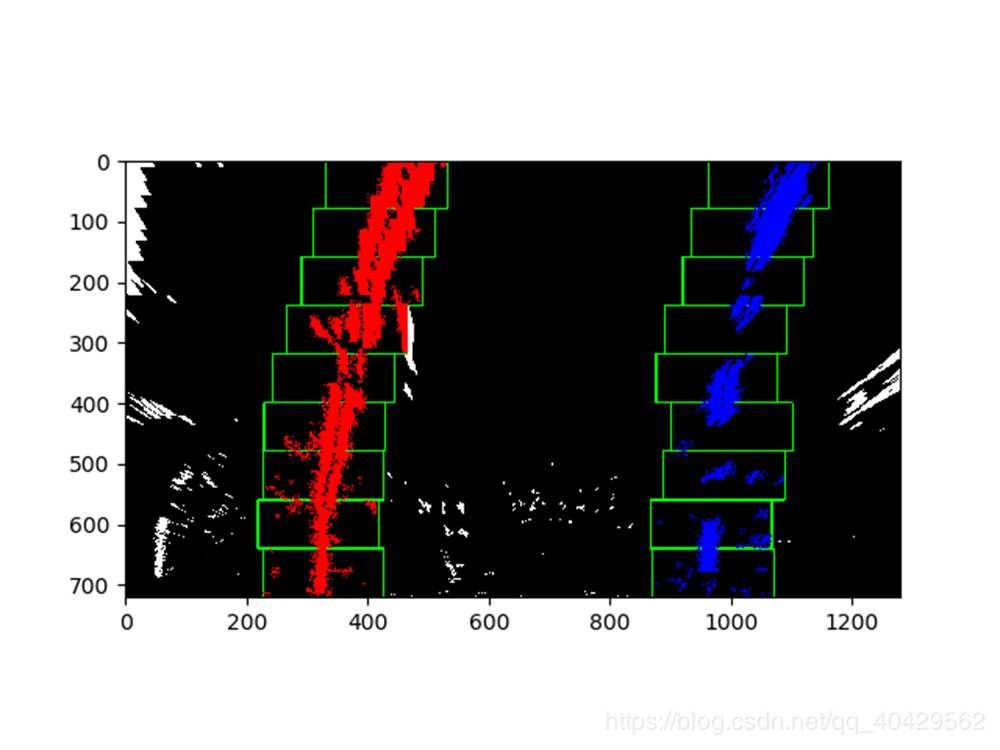

In [14]:
#滑窗取点

nwindows = 25  #滑窗个数
window_height = int(binary_warped.shape[0]/nwindows)  #滑窗高度
nonzero = binary_warped.nonzero()  #非0的坐标值
#print(nonzero)        
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
lane_current = lane_base
#print(nonzerox)          
margin = 25
minpix = 25
           
lane_inds = []
      
img1 = cv2.cvtColor(binary_warped, cv2.COLOR_GRAY2BGR) 
for window in range(nwindows):
    win_y_low = binary_warped.shape[0] - (window + 1) * window_height            
    win_y_high = binary_warped.shape[0] - window*window_height             
    win_x_low = lane_current - margin             
    win_x_high = lane_current + margin 
    good_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) 
                 & (nonzerox >= win_x_low) & (nonzerox < win_x_high)).nonzero()[0]
    cv2.rectangle(img1,(win_x_low,win_y_low),(win_x_high,win_y_high),(0,0,255),3)
                  
    lane_inds.append(good_inds)
            
    if len(good_inds) > minpix:
        lane_current = int(np.mean(nonzerox[good_inds])) 

cv2.imshow("img1",img1)
#print(lane_base)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [15]:
#拟合成一元二次方程
lane_inds = np.concatenate(lane_inds) 
pixelX=nonzerox[lane_inds]
pixelY=nonzeroy[lane_inds]
fit = np.polyfit(pixelY, pixelX, 2)
ploty =np.array(list(set(pixelY)))

plotx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
num = 0
for num in range(len(ploty)-1):
    cv2.line(img1, (int(plotx[num]),int(ploty[num])),(int(plotx[num+1]),int(ploty[num+1])),(0,255,0), 10)    

cv2.imshow("img1",img1)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [36]:
#确定目标点
import math
aP = [0.0,0.0]

if(lane_base >=640):
    LorR = -1.0  #Right
else:
    LorR = 1.0  #Left

aimLaneP = [int(plotx[len(ploty)//2]),int(ploty[len(ploty)//2])] 
img1 = cv2.circle(img1, (aimLaneP[0],aimLaneP[1]), 25, (255,0,0), -1)

lanePk =(1/(2*fit[0]))*aimLaneP[0] - fit[1]/(2*fit[0])
k_ver = -1/lanePk
theta = math.atan(k_ver)
aP[0] = aimLaneP[0] + math.cos(theta)*(LorR)*width_pers/2
aP[1] = aimLaneP[1] + math.sin(theta)*(LorR)*width_pers/2
  
img1 = cv2.circle(img1, (int(aP[0]),int(aP[1])), 25, (0,255,0), -1)

    
cv2.imshow("img1",img1)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [38]:
#附到原图上
Minv = cv2.getPerspectiveTransform(dstps,srcps)
newwarp = cv2.warpPerspective(img1, Minv, img1.shape[1::-1]) 
    # Combine the result with the original image
    
result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
cv2.imshow("result",newwarp)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [30]:
#完整程序 一张图
import cv2
import numpy as np
import math

startx = 307
starty = 700
length_pers = 680
width_pers = 665
aP = [0.0,0.0]
dstps = np.float32([[(startx, starty), (startx, starty - length_pers), (startx + width_pers, starty - length_pers),
                    (startx + width_pers, starty)]])

srcps = np.array([[238., 681.], [546., 497.], [762., 483.], [1069., 678.]], dtype="float32")
M = cv2.getPerspectiveTransform(srcps, dstps)
Minv = cv2.getPerspectiveTransform(dstps,srcps)
img = cv2.imread('f:/lane/lane_3.png')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)


binary = np.zeros_like(gray)
binary[(gray >= 127)] = 255 

binary_Blur = cv2.morphologyEx(binary, cv2.MORPH_OPEN,kernel) #开运算

binary_warped = cv2.warpPerspective(binary_Blur, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)
img1 = cv2.cvtColor(binary_warped, cv2.COLOR_GRAY2BGR) 
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)     

lane_base = np.argmax(histogram)
nwindows = 25
window_height = int(binary_warped.shape[0]/nwindows)
nonzero = binary_warped.nonzero()
#print(nonzero)        
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
lane_current = lane_base
        
margin = 25
minpix = 25
           
lane_inds = []
      
img1 = cv2.cvtColor(binary_warped, cv2.COLOR_GRAY2BGR) 
for window in range(nwindows):
    win_y_low = binary_warped.shape[0] - (window + 1) * window_height            
    win_y_high = binary_warped.shape[0] - window*window_height             
    win_x_low = lane_current - margin             
    win_x_high = lane_current + margin 
    good_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_x_low) & (nonzerox < win_x_high)).nonzero()[0]
    #cv2.rectangle(img1,(win_x_low,win_y_low),(win_x_high,win_y_high),(0,0,255),3)
                  
    lane_inds.append(good_inds)
            
    if len(good_inds) > minpix:
        lane_current = int(np.mean(nonzerox[good_inds])) 

#print(lane_inds)
lane_inds = np.concatenate(lane_inds) 
pixelX=nonzerox[lane_inds]
pixelY=nonzeroy[lane_inds]
fit = np.polyfit(pixelY, pixelX, 2)
#p1 = np.poly1d(fit)
#print(p1)
#pixlY_max = max(pixelY)
ploty =np.array(list(set(pixelY)))
#print(ploty)
plotx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
num = 0
for num in range(len(ploty)-1):
    cv2.line(img1, (int(plotx[num]),int(ploty[num])),(int(plotx[num+1]),
                                                      int(ploty[num+1])),(0,255,0), 10)
    
aP = [0.0,0.0]

if(lane_base >=620):
    LorR = -1.0  #Right
else:
    LorR = 1.0  #Left


aimLaneP = [int(plotx[len(ploty)//2]),int(ploty[len(ploty)//2])] 
img1 = cv2.circle(img1, (aimLaneP[0],aimLaneP[1]), 25, (255,0,0), -1)

lanePk =(1/(2*fit[0]))*aimLaneP[0] - fit[1]/(2*fit[0])
k_ver = -1/lanePk
theta = math.atan(k_ver)
aP[0] = aimLaneP[0] + math.cos(theta)*(LorR)*width_pers/2
aP[1] = aimLaneP[1] + math.sin(theta)*(LorR)*width_pers/2
  
img1 = cv2.circle(img1, (int(aP[0]),int(aP[1])), 25, (0,0,255), -1)

newwarp = cv2.warpPerspective(img1, Minv, img1.shape[1::-1]) 
    # Combine the result with the original image
    
result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
cv2.imshow("result",result)    
cv2.waitKey(0)
cv2.destroyAllWindows()

In [22]:
#完整视频程序，缺目标点
import cv2
import numpy as np

startx = 307
starty = 700
length_pers = 680
width_pers = 665

dstps = np.float32([[(startx, starty), (startx, starty - length_pers), 
                     (startx + width_pers, starty - length_pers), (startx + width_pers, starty)]])

srcps = np.array([[238., 681.], [546., 497.], [762., 483.], [1069., 678.]], dtype="float32")
M = cv2.getPerspectiveTransform(srcps, dstps)
Minv = cv2.getPerspectiveTransform(dstps,srcps)



cap = cv2.VideoCapture("f:/lane/lane_3.mp4")
ret = cap.isOpened()

fourcc = cv2.VideoWriter_fourcc('X', 'V', 'I', 'D') #MP4格式
w = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
h = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)

out = cv2.VideoWriter('f:/lane/lane_out_withbackg.mp4', fourcc, 50, (int(w), int(h)))



def find_line(binary_warped):
    # Take a histogram of the bottom half of the image
    #histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    histogram = np.sum(binary_warped[:,:], axis=0)
    
    img1 = cv2.cvtColor(binary_warped, cv2.COLOR_GRAY2BGR) 
    num = 0
    for num in range(len(histogram)-1):
        cv2.line(img1, (num,int(720-histogram[num]/200)),(num+1,int(720-histogram[num+1]/200)),(255,255,0), 5)
       
       
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 25
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 25
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            cv2.rectangle(img1,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(255,0,255),3)
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            cv2.rectangle(img1,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(255,0,255),3)

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    num = 0
    for num in range(len(ploty)-1):
        cv2.line(img1, (int(left_fitx[num]),int(ploty[num])),(int(left_fitx[num+1]),int(ploty[num+1])),(0,0,255), 20)
        cv2.line(img1, (int(right_fitx[num]),int(ploty[num])),(int(right_fitx[num+1]),int(ploty[num+1])),(0,0,255), 20)
    
    
    vertices = np.array([[(int(left_fitx[0]),int(ploty[0])),(int(left_fitx[num-1]),int(ploty[num-1])),
                          (int(right_fitx[num-1]),int(ploty[num-1])),(int(right_fitx[0]),int(ploty[0]))]])
    cv2.fillPoly(img1, vertices,(0,255, 0))
    return img1
                
while(ret):
    ret, frame = cap.read()
    if ret ==True:
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  #彩色图片转换成灰度
    
        origin_thr = np.zeros_like(gray)  #尺寸一致的黑色图
        origin_thr[(gray >= 165)] = 255  
    
        kernel = np.ones((3,3),np.uint8)
        gray_Blur = cv2.morphologyEx(origin_thr, cv2.MORPH_OPEN,kernel) #开运算
    
        binary_warped = cv2.warpPerspective(gray_Blur, M, frame.shape[1::-1], flags=cv2.INTER_LINEAR) #透视变换
    
        color_warp=find_line(binary_warped)
        cv2.imshow("img1",color_warp)

        newwarp = cv2.warpPerspective(color_warp, Minv, frame.shape[1::-1]) 
    # Combine the result with the original image
    
        result = cv2.addWeighted(frame, 1, newwarp, 0.3, 0)
        cv2.imshow("result",result)
        out.write(result)
    
        k = cv2.waitKey(75)
        if( k   == ord('q')):
              break
                
                
                
cv2.waitKey(0)                  
cap.release()
cv2.destroyAllWindows()


C:\Users\Alkdis\AppData\Local\Temp\ipykernel_17720\2453801280.py:44: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0]/2)
C:\Users\Alkdis\AppData\Local\Temp\ipykernel_17720\2453801280.py:51: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the rele